# Piano per lo svolgimento

1) Scegliere se discretizzare e normalizzare prima o dopo la suddivisione in time series mensili. L'importante è che la codifica dei bins sia la stessa per tutte le time series

2) Se decidiamo di effettuare una discretizzazione "statica", allora è consigliato rimuovere i linear trend dalle series

3) Riguardo alla rimozione del noise, valutare sperimentalmente cosa succede con o senza di essa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16,4

Populating the interactive namespace from numpy and matplotlib


## Dataset: IBM stock values from 1962 to 2018

In [3]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep=',',header=0)

/usr/local/lib/python2.7/dist-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


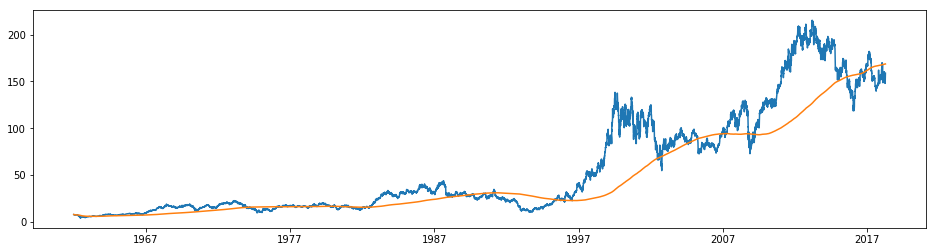

In [4]:
plt.plot(series)
plt.plot(series.rolling(window=2000, min_periods=1).mean())

## Time series da cui partire
Due casi: con noise e senza noise

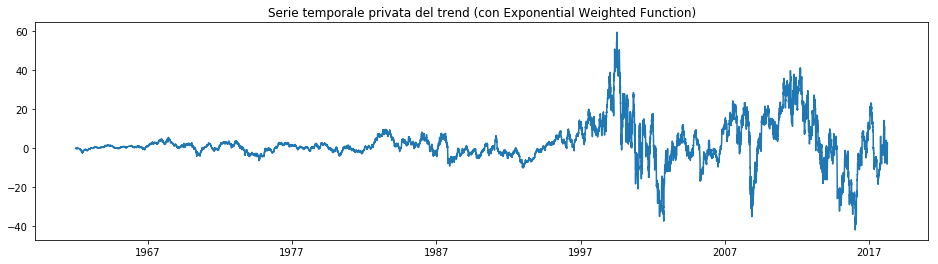

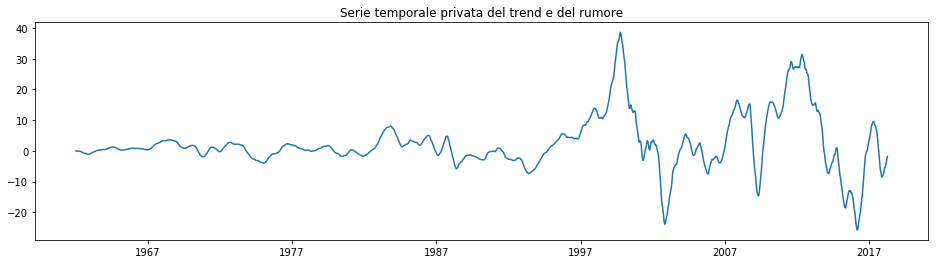

In [5]:
# linear_trend = series.rolling(window=2000, min_periods=1).mean()
# untrended = series - linear_trend
# series_untr = pd.Series(untrended, series.index)
# plt.plot(series_untr)
# plt.figure()
# untr_no_noise = series_untr.rolling(window=200, min_periods=1).mean()
# plt.plot(untr_no_noise)

plt.figure()
exp_decay_series = pd.Series(series - series.ewm(halflife=150).mean(), series.index)
plt.title('Serie temporale privata del trend (con Exponential Weighted Function)')
plt.plot(exp_decay_series)

plt.figure()
decay_no_noise = exp_decay_series.rolling(window=150, min_periods=1).mean()
plt.title('Serie temporale privata del trend e del rumore')
plt.plot(decay_no_noise)

## Suddivisione in time series mensili (676 serie), discretizzazione e normalizzazione

In [29]:
from pandas import TimeGrouper
from pandas import DataFrame

#--------------------------------------------------------------------------------------------------------------
#                      Suddivisione in 676 serie mensili, normalizzazione dei valori
#                     e discretizzazione (utilizzando un numero fissato di intervalli)
#--------------------------------------------------------------------------------------------------------------

groups = exp_decay_series.groupby(TimeGrouper('M'))

mm = dict()
for name, group in groups:
    
    # Normalizzazione Z-score dei valori (non fondamentale in questa fase)
    norm_values = (group.values - mean(group.values)) / std(group.values)
    
    # Nella relazione, possiamo usare le etichette ['A','B','C','D','E','F','G','H']
    # per identificare gli intervalli
    discretized_values = pd.cut(norm_values, 8, labels=False)
    
    mm["%s-%s" % (name.year,name.month)] = discretized_values


/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if __name__ == '__main__':


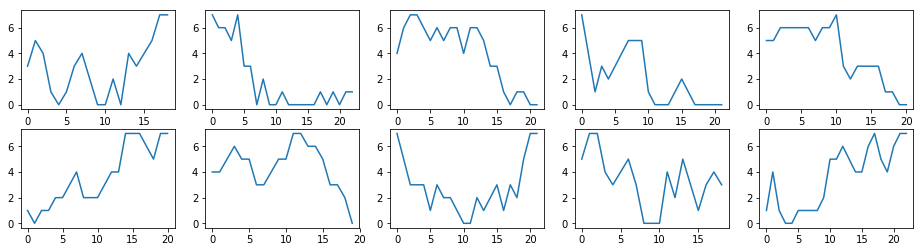

In [7]:
import itertools
fig = plt.figure()
size_of_fig = (2, 5)
positions = itertools.product(range(2), range(5))
for pos, v in zip(positions, mm.values()[:10]):
    plt.subplot2grid(size_of_fig, pos)
    plt.plot(range(len(v)), v)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


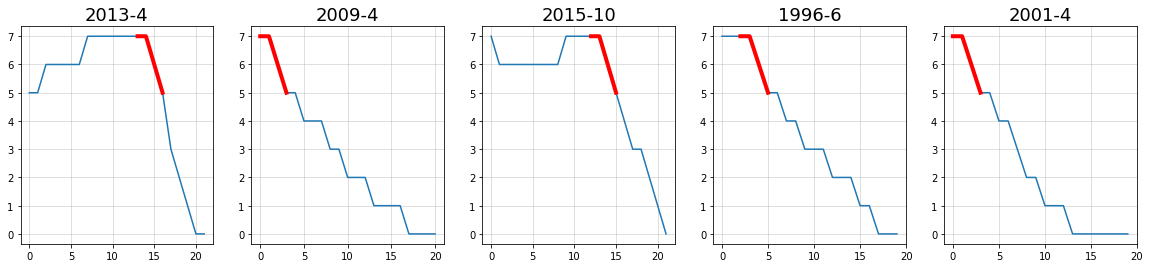

In [80]:
b = [7,7,6,5]

occurrences=[]
for (k, v) in mm.items():
    a = [a for a in v]
    occs = ([(i, i+len(b)) for i in range(len(a)) if a[i:i+len(b)] == b])
    if len(occs) > 0:
        occurrences.append((occs, v, k))
        
        
fig_locations = list(itertools.product(range(1), range(5)))
print fig_locations
plt.figure(figsize=(20,4))
for (i, pos) in zip(range(24,29), fig_locations):
    positions = occurrences[i][0]
    #if len(positions) <= 1:
    #    continue
    vals = occurrences[i][1]
    
    x = range(len(vals))
    plt.subplot2grid((1,5), pos)
    plt.plot(x, vals)
    plt.grid(alpha=0.5)
    plt.title(occurrences[i][2], fontsize=18)
    
    
    for p in positions:
        
        plt.plot(x[p[0]:p[1]], b, 'r-', linewidth=4)

In [52]:
# -------------------------------------------------------------------------------------------------------------
#                          Scrittura del file nel formato SPMF descritto in
#                    http://www.philippe-fournier-viger.com/spmf/HirateYamana.php
#--------------------------------------------------------------------------------------------------------------
    
mhanz = open("progetto_DM_seq_mensili.txt", "w")

for k in mm.keys():
    vals = mm[k]
    contatore_tempo = 0
    for v in vals:
        mhanz.write('<%s> %s -1 ' % (contatore_tempo, v))
        contatore_tempo = contatore_tempo + 1
    
    mhanz.write('-2\n')
    
mhanz.close()

## Replichiamo l'esperimento, ma stavolta sulla Time Series privata del noise

In [54]:
from pandas import TimeGrouper
from pandas import DataFrame

#--------------------------------------------------------------------------------------------------------------
#                      Suddivisione in 676 serie mensili, normalizzazione dei valori
#                     e discretizzazione (utilizzando un numero fissato di intervalli)
#--------------------------------------------------------------------------------------------------------------

groups = decay_no_noise.groupby(TimeGrouper('M'))

mm = dict()
for name, group in groups:
    
    # Normalizzazione Z-score dei valori (non fondamentale in questa fase)
    norm_values = (group.values - mean(group.values)) / std(group.values)
    
    # Nella relazione, possiamo usare le etichette ['A','B','C','D','E','F','G','H']
    # per identificare gli intervalli
    discretized_values = pd.cut(norm_values, 8, labels=False)
    
    mm["%s-%s" % (name.year,name.month)] = discretized_values
    


/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if __name__ == '__main__':


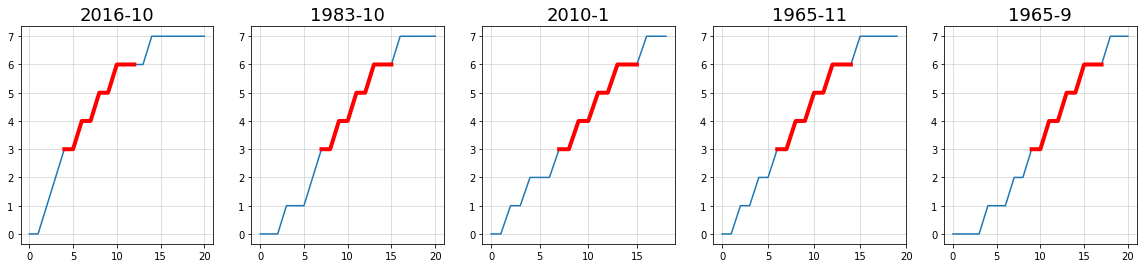

In [156]:
import random
b = [3,3,4,4,5,5,6,6,6]

occurrences=[]
for (k, v) in mm.items():
    a = [a for a in v]
    occs = ([(i, i+len(b)) for i in range(len(a)) if a[i:i+len(b)] == b])
    if len(occs) > 0:
        occurrences.append((occs, v, k))

fig_locations = list(itertools.product(range(1), range(5)))
        
plt.figure(figsize=(20,4))
for (i, pos) in zip(random.sample(range(len(occurrences)), 5), fig_locations):
    positions = occurrences[i][0]
    #if len(positions) <= 1:
    #    continue
    vals = occurrences[i][1]
    
    x = range(len(vals))
    plt.subplot2grid((1,5), pos)
    plt.plot(x, vals)
    plt.title(occurrences[i][2], fontsize=18)
    plt.grid(alpha=0.5)
    
    for p in positions:
        plt.plot(x[p[0]:p[1]], b, 'r-', linewidth=4)

In [90]:
#--------------------------------------------------------------------------------------------------------------
#                          Scrittura del file nel formato SPMF descritto in
#                    http://www.philippe-fournier-viger.com/spmf/HirateYamana.php
#--------------------------------------------------------------------------------------------------------------
    
mhanz = open("progetto_DM_seq_mensili(no_noise).txt", "w")

for k in mm.keys():
    vals = mm[k]
    contatore_tempo = 0
    for v in vals:
        mhanz.write('<%s> %s -1 ' % (contatore_tempo, v))
        contatore_tempo = contatore_tempo + 1
    
    mhanz.write('-2\n')
    
mhanz.close()